# Experiment: Digits Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F


train=pd.read_csv('optdigits_tra.txt',header=None,sep = ',')
train_y=train.iloc[:,64]
trainx=train.iloc[:,:64]
train=pd.read_csv('optdigits_tes.txt',header=None,sep = ',')
test_y=train.iloc[:,64]
testx=train.iloc[:,:64]
print(len(trainx),len(testx))

total_x=pd.concat([trainx,testx])
x=preprocessing.StandardScaler().fit(total_x).transform(total_x) #normalize
x=pd.DataFrame(x)

train_x=x.iloc[:len(trainx)]
test_x=x.iloc[len(trainx):]

train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True)

train_y=pd.get_dummies(train_y)
test_y=pd.get_dummies(test_y)

train_x ##display the data

3823 1797


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.793133,0.129863,0.748317,0.094508,-0.815851,-0.410972,-0.132062,-0.035424,1.622966,...,-0.761830,-0.197899,-0.018868,-0.303102,0.047703,0.462445,-0.919036,-0.983796,-0.517244,-0.179136
1,0.0,-0.343381,0.985972,0.983303,-1.250136,-0.993451,-0.410972,-0.132062,-0.035424,1.622966,...,-0.150393,-0.197899,-0.018868,-0.303102,0.844405,0.922516,0.688929,-0.639861,-0.517244,-0.179136
2,0.0,-0.343381,0.557918,0.748317,0.990937,1.315342,-0.410972,-0.132062,-0.035424,-0.313430,...,-0.761830,-0.197899,-0.018868,-0.303102,0.645229,0.462445,-2.326006,-1.155764,-0.517244,-0.179136
3,0.0,-0.343381,-1.154300,-2.071514,-0.129599,1.848140,-0.410972,-0.132062,-0.035424,-0.636162,...,-0.761830,-0.197899,-0.018868,-0.303102,-1.147350,-2.528016,0.688929,-0.811828,-0.517244,-0.179136
4,0.0,-0.343381,-0.084164,0.513331,-1.698350,-0.993451,-0.410972,-0.132062,-0.035424,-0.636162,...,1.683918,-0.197899,-0.018868,-0.303102,-0.350648,0.002374,0.487933,0.048010,-0.517244,-0.179136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,0.0,-0.343381,-0.084164,0.278345,-0.129599,-0.638252,-0.410972,-0.132062,-0.035424,0.009303,...,1.276294,-0.197899,-0.018868,-0.303102,0.446054,0.232410,0.688929,0.563913,-0.270183,-0.179136
3819,0.0,-0.343381,-1.154300,-2.541486,0.094508,-0.815851,-0.410972,-0.132062,-0.035424,-0.636162,...,-0.761830,-0.197899,-0.018868,-0.303102,-1.147350,-1.837910,-0.517045,-1.155764,-0.517244,-0.179136
3820,0.0,-0.343381,-0.512218,0.748317,-2.594779,-0.993451,-0.410972,-0.132062,-0.035424,-0.636162,...,0.053419,-0.197899,-0.018868,-0.303102,-0.350648,0.462445,0.889924,0.391946,-0.517244,-0.179136
3821,0.0,-0.343381,0.129863,0.983303,-2.146565,-0.993451,-0.410972,-0.132062,-0.035424,-0.636162,...,2.295356,-0.197899,-0.018868,-0.303102,-0.151473,0.922516,0.889924,1.595719,0.718057,-0.179136


In [2]:
train_y

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3818,0,0,0,0,0,0,0,0,0,1
3819,0,0,0,0,1,0,0,0,0,0
3820,0,0,0,0,0,0,1,0,0,0
3821,0,0,0,0,0,0,1,0,0,0


In [3]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [41]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 10)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return  self.softmax(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=5e-2,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(200): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    dnn_trainloss.append(float(train_loss))
    dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
epoch 0
            Train set - loss: 2.3243956565856934
            Test  set - loss: 2.3392550945281982
            
epoch 10
            Train set - loss: 1.730626106262207
            Test  set - loss: 1.8703356981277466
            
epoch 20
            Train set - loss: 1.5816638469696045
            Test  set - loss: 1.639090657234192
            
epoch 30
            Train set - loss: 1.5473541021347046
            Test  set - loss: 1.5666553974151611
            
epoch 40
            Train set - loss: 1.571662187576294
            Test  set - loss: 1.5558172464370728
            
epoch 50
            Train set - loss: 1.5671839714050293
            Test  set - loss: 1.5593972206115723
            
epoch 60
            Train set - loss: 1.5533735752105713
            T

In [42]:
#predict
accu=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        if np.array(pred).reshape(-1).argmax()==test_y[i:i+1].to_numpy().argmax():
            accu=accu+1
print(accu/len(test_x))

0.9465776293823038


## 2. Resnet

In [43]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(64,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,10)
        self.softmax = nn.Softmax(dim=1)
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        x = self.fc3(x)
        return self.softmax(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.CrossEntropyLoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-2,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(200): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    res_trainloss.append(float(train_loss))
    res_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=64, out_features=32, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
epoch 0
            Train set - loss: 2.308274030685425
            Test  set - loss: 2.291105270385742
            
epoch 10
            Train set - loss: 2.128049373626709
            Test  set - loss: 2.0637550354003906
            
epoch 20
            Train set - loss: 2.0098583698272705
            Test  set - loss: 1.9731709957122803
            
epoch 30
            Train set - loss: 1.82774019241333
            Test  set - loss: 1.7702937126159668
            
epoch 40
            Train set - loss: 1.712468147277832
            Test  set - loss: 1.7351666688919067
            


In [44]:
#predict
accu=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        if np.array(pred).reshape(-1).argmax()==test_y[i:i+1].to_numpy().argmax():
            accu=accu+1
print(accu/len(test_x))

0.9499165275459098


## Random Feature

definition of random feature

In [13]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

## 3. multilayer learning

In [189]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(64,32,kernel='L',gamma=0.1)
rff2=RandomFourierFeature(16,8,kernel='G',gamma=1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(8, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        x = self.fc2(x)
        return self.softmax(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.CrossEntropyLoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-1,momentum=0.9) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(500): 
    if epoch>100:
        optimizer=optim.SGD(net.parameters(),lr=5e-2,momentum=0.9) #optim.Adam(...)
    if epoch>300:
        optimizer=optim.SGD(net.parameters(),lr=3e-2,momentum=0.9) #optim.Adam(...)
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=8, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
epoch 0
            Train set - loss: 2.3041183948516846
            Test  set - loss: 2.301081657409668
            
epoch 10
            Train set - loss: 1.9831819534301758
            Test  set - loss: 2.122779369354248
            
epoch 20
            Train set - loss: 1.9460135698318481
            Test  set - loss: 1.9332396984100342
            
epoch 30
            Train set - loss: 1.9887549877166748
            Test  set - loss: 1.8402280807495117
            
epoch 40
            Train set - loss: 1.9120169878005981
            Test  set - loss: 1.748017430305481
            
epoch 50
            Train set - loss: 1.7271771430969238
            Test  set - loss: 1.6726313829421997
            
epoch 60
            Train set - loss: 1.7647796869277954
            Test  set - loss: 1.6369349956512451
            
epoc

In [190]:
#predict
accu=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        if np.array(pred).reshape(-1).argmax()==test_y[i:i+1].to_numpy().argmax():
            accu=accu+1
print(accu/len(test_x))

0.8135781858653311


## 4. Residual multilayer learning

In [184]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(64,32,kernel='L',gamma=0.05)
rff1=RandomFourierFeature(32,8,kernel='L',gamma=0.5)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=5)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        y = rff.transform(x)
        x = self.fc1(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.rblock2 = ResidualBlock(8,8,rff2)
        self.fc3 = nn.Linear(8, 10)
        self.softmax = nn.Softmax(dim=1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        x = self.rblock2(x)
        x = self.fc3(x)
        return self.softmax(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.CrossEntropyLoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-2,momentum=0.9) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(500): 
    if epoch>100:
        optimizer=optim.SGD(net.parameters(),lr=1e-2,momentum=0.9) #optim.Adam(...)
    if epoch>200:
        optimizer=optim.SGD(net.parameters(),lr=2e-3,momentum=0.9) #optim.Adam(...)
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
    reskernel_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=8, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
epoch 0
            Train set - loss: 2.3030643463134766
            Test  set - loss: 2.3025155067443848
            
epoch 10
            Train set - loss: 2.250908613204956
            Test  set - loss: 2.2725887298583984
            
epoch 20
            Train set - loss: 2.2342379093170166
            Test  set - loss: 2.2225468158721924
            
epoch 30
            Train set - loss: 2.036613702774048
            Test  set - loss: 2.124953269958496
            
epoch 40
            Train set - loss: 2.192288875579834
            Test  set - loss: 2.179643392562866
           

In [185]:
#predict
accu=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        if np.array(pred).reshape(-1).argmax()==test_y[i:i+1].to_numpy().argmax():
            accu=accu+1
print(accu/len(test_x))

0.8013355592654424


DNN vs multilayer kernel

In [186]:
def plot_choose(fig,start,data):
    fig.plot(np.arange(start,len(data)),data[start:])

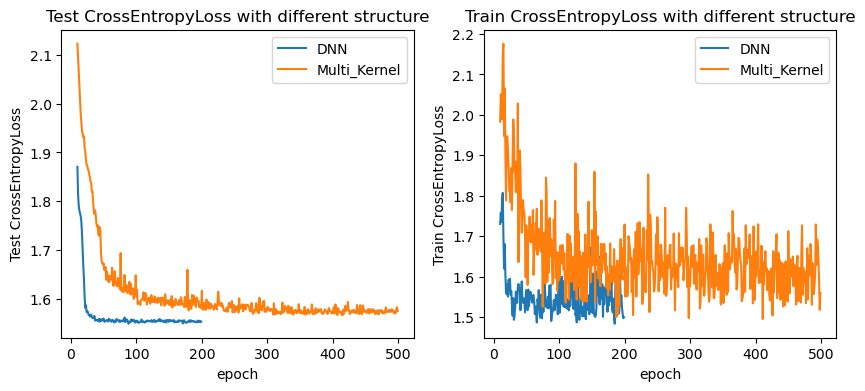

In [191]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],10,dnn_testloss)
plot_choose(ax[0],10,kernelnn_testloss)
ax[0].legend(["DNN","Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test CrossEntropyLoss")
ax[0].set_title("Test CrossEntropyLoss with different structure")

plot_choose(ax[1],10,dnn_trainloss)
plot_choose(ax[1],10,kernelnn_trainloss)
ax[1].legend(["DNN","Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train CrossEntropyLoss")
ax[1].set_title("Train CrossEntropyLoss with different structure")
plt.show()

Resnet vs multilayer residual kernel

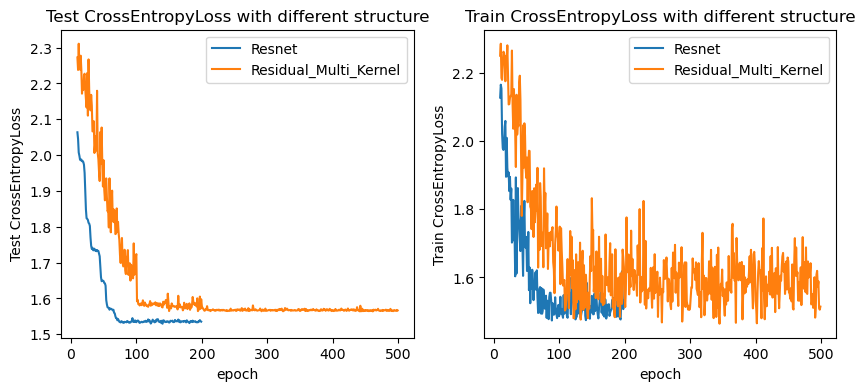

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],10,res_testloss)
plot_choose(ax[0],10,reskernel_testloss)
ax[0].legend(["Resnet","Residual_Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test CrossEntropyLoss")
ax[0].set_title("Test CrossEntropyLoss with different structure")

plot_choose(ax[1],10,res_trainloss)
plot_choose(ax[1],10,reskernel_trainloss)
ax[1].legend(["Resnet","Residual_Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train CrossEntropyLoss")
ax[1].set_title("Train CrossEntropyLoss with different structure")
plt.show()